# Explorando movimientos propios por correlación cruzada

Este notebook usa widgets. Se requiere

```
uv add jupyterlab ipykernel jupyterlab-widgets ipympl ipywidgets
uv add matplotlib seaborn
uv add scipy astropy regions
uv add cyclopts
```


In [1]:
from orion_jets import xcorr2d, fileio
from astropy.modeling import models 
import numpy as np
from pathlib import Path
%matplotlib widget
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
xcorr2d.measure_shift_integer?

Signature:
xcorr2d.measure_shift_integer(
    img_ref: numpy.ndarray,
    img_new: numpy.ndarray,
) -> tuple[float, float]
Docstring:
Measure (dy, dx) that best aligns img_new onto img_ref using 2D cross-correlation.

Convention:
    img_new(y + dy, x + dx) ≈ img_ref(y, x)
so positive dy, dx mean img_new must be shifted down/right to match img_ref.
File:      ~/Dropbox/Teaching/Computacional/dev-clases-2025/project-repos/orion-jets/src/orion_jets/xcorr2d.py
Type:      function

In [4]:
def make_gaussian_image(x0: float, y0: float, shape: tuple[int, int]=(10, 10), sigma: float=2.0) -> np.ndarray:
    """
    Image of single Gaussian peak centered at pixel coords [y0, x0] 
    """
    ny, nx = shape
    y, x = np.mgrid[0:ny, 0:nx]
    dx = (x - x0) / sigma
    dy = (y - y0) / sigma
    # 2D isotropic Gaussian, unit amplitude
    return np.exp(-0.5 * (dx*dx + dy*dy))
    

In [6]:
np.round(make_gaussian_image(5, 5), 2)

array([[0.  , 0.01, 0.01, 0.03, 0.04, 0.04, 0.04, 0.03, 0.01, 0.01],
       [0.01, 0.02, 0.04, 0.08, 0.12, 0.14, 0.12, 0.08, 0.04, 0.02],
       [0.01, 0.04, 0.11, 0.2 , 0.29, 0.32, 0.29, 0.2 , 0.11, 0.04],
       [0.03, 0.08, 0.2 , 0.37, 0.54, 0.61, 0.54, 0.37, 0.2 , 0.08],
       [0.04, 0.12, 0.29, 0.54, 0.78, 0.88, 0.78, 0.54, 0.29, 0.12],
       [0.04, 0.14, 0.32, 0.61, 0.88, 1.  , 0.88, 0.61, 0.32, 0.14],
       [0.04, 0.12, 0.29, 0.54, 0.78, 0.88, 0.78, 0.54, 0.29, 0.12],
       [0.03, 0.08, 0.2 , 0.37, 0.54, 0.61, 0.54, 0.37, 0.2 , 0.08],
       [0.01, 0.04, 0.11, 0.2 , 0.29, 0.32, 0.29, 0.2 , 0.11, 0.04],
       [0.01, 0.02, 0.04, 0.08, 0.12, 0.14, 0.12, 0.08, 0.04, 0.02]])

In [7]:
im1 = make_gaussian_image(5.5, 5.5)
im2 = make_gaussian_image(7.5, 7.5)
xcorr2d.measure_shift_integer(im1, im2)

(-2.0, -2.0)

In [8]:
datapath = Path.cwd().parent / "data"
datapath

PosixPath('/Users/will/Dropbox/Teaching/Computacional/dev-clases-2025/project-repos/orion-jets/data')

What FITS files do we have

In [9]:
sorted(map(lambda p: p.name, datapath.glob("*")))

['cutout-hh529-acs-2005.fits',
 'cutout-hh529-jwst-f187n-2022.fits',
 'cutout-hh529-wfc3-2015.fits',
 'hh529-boxes.reg']

In [10]:
hdu1 = fileio.get_first_data_hdu(datapath / "cutout-hh529-acs-2005.fits")
hdu2 = fileio.get_first_data_hdu(datapath / "cutout-hh529-wfc3-2015.fits")
boxes = fileio.get_box_region_masks(datapath / "hh529-boxes.reg")

In [11]:
boxes

{'E jet A': <regions.core.mask.RegionMask at 0x130302a50>}

We have only one box, so we can unpack like this.

In [12]:
(label, box), = boxes.items()

In [13]:
im1 = box.cutout(hdu1.data)
im2 = box.cutout(hdu2.data)

In [14]:
im1 = xcorr2d.regularize(im1)
im2 = xcorr2d.regularize(im2)

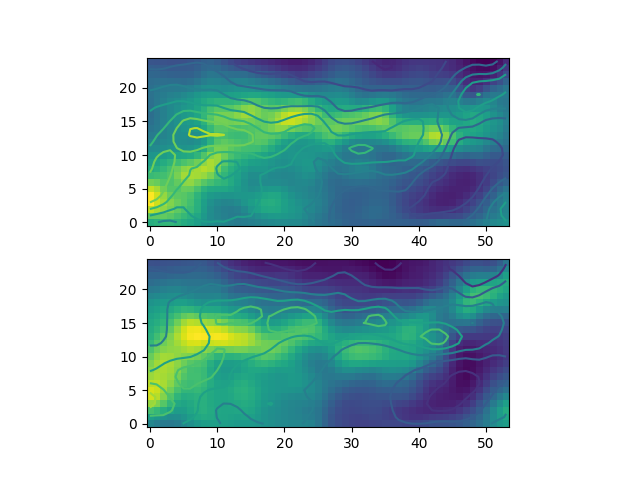

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(im1, origin="lower")
ax1.contour(im2)
ax2.imshow(im2, origin="lower")
ax2.contour(im1)

In [16]:
import ipywidgets as widgets


ToggleButtons(options=(('2005', 0), ('2015', 1)), value=0)

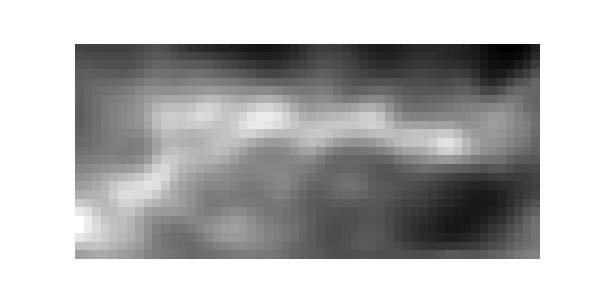

In [17]:
fig, ax = plt.subplots(figsize=(6, 3))
im = ax.imshow(im1, cmap='gray', origin="lower")
plt.axis('off')

def on_change(change):
    im.set_data(im1 if change['new']==0 else im2)
    fig.canvas.draw_idle()

toggle = widgets.ToggleButtons(options=[('2005',0), ('2015',1)])
toggle.observe(on_change, names='value')
toggle

In [18]:
from scipy import signal


In [19]:
corr = signal.correlate2d(
    im1,
    im2,
    mode="full",
    boundary="fill",
    fillvalue=0.0,
)


In [20]:
jmax, imax = xcorr2d.max_location_indices(corr)
jmax, imax

(np.int64(24), np.int64(56))

In [21]:
oy, ox = im1.shape[0] - 1, im1.shape[1] - 1
oy, ox

(24, 53)

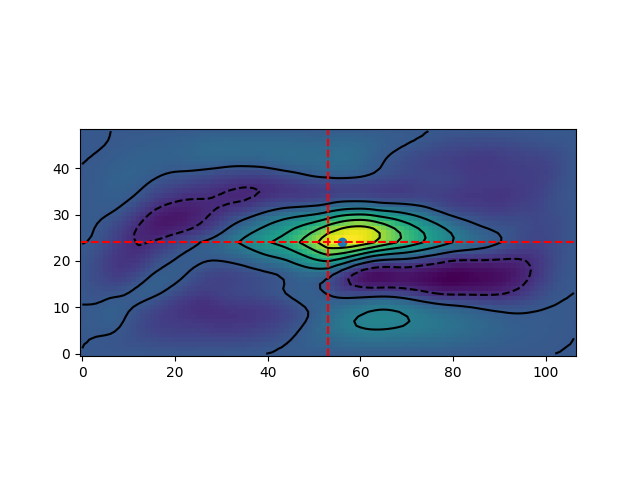

In [22]:
fig, ax = plt.subplots()
ax.imshow(corr, origin="lower")
ax.contour(corr, colors="k")
ax.axhline(oy, color="r", ls="dashed")
ax.axvline(ox, color="r", ls="dashed")
ax.scatter([imax], [jmax])

In [23]:
g, gim = xcorr2d.measure_shift_gfit(im1, im2)

In [24]:
g

<Gaussian2D(amplitude=1024.61074987, x_mean=57.33291036, y_mean=25.19569651, x_stddev=11.2431228, y_stddev=2.92103061, theta=0.0726015)>

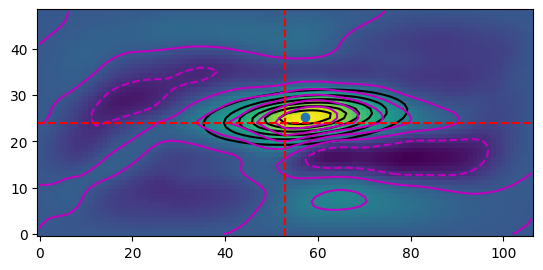

In [25]:
fig, ax = plt.subplots()
ax.imshow(corr, origin="lower")
ax.contour(gim, colors="k")
ax.contour(corr, colors="m")
ax.axhline(oy, color="r", ls="dashed")
ax.axvline(ox, color="r", ls="dashed")
ax.scatter([g.x_mean.value], [g.y_mean.value])
fig

In [30]:
dx = g.x_mean - ox
dy = g.y_mean - oy
f"Desplazamiento = ({dx:.2f}, {dy:.2f})"

'Desplazamiento = (4.33, 1.20)'

### Checar la autocorrelación

In [26]:
corr11 = signal.correlate2d(
    im1,
    im1,
    mode="full",
    boundary="fill",
    fillvalue=0.0,
)


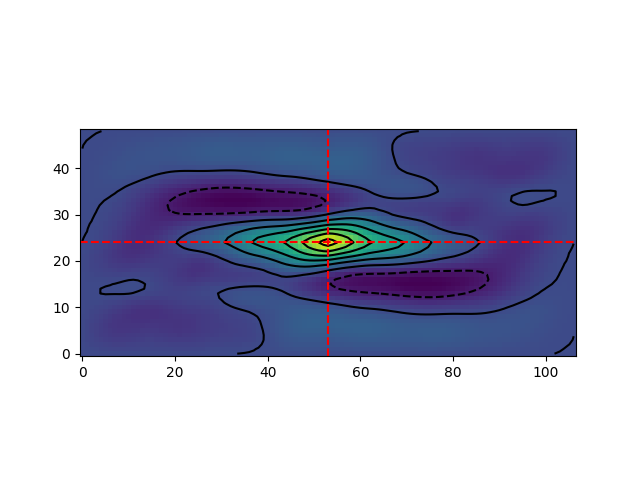

In [27]:
fig, ax = plt.subplots()
ax.imshow(corr11, origin="lower")
ax.contour(corr11, colors="k")
ax.axhline(oy, color="r", ls="dashed")
ax.axvline(ox, color="r", ls="dashed")

Check that we get zero shift of image with itself

In [28]:
np.unravel_index._implementation.__module__

'numpy._core._multiarray_umath'